In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score, silhouette_samples
# import mglearn
import warnings
import random
import os

warnings.filterwarnings(action='ignore')
filename = os.path.join(os.getcwd(),'null_delete_MB1.csv')
raw_data = pd.read_csv(filename,index_col=False)
raw_data = raw_data.iloc[:,1:]
print('-- Finish Read Data --')

fail_disk_id = raw_data[raw_data['label']==1]['disk_id'].unique()
fail_disk_concat = []
for i in fail_disk_id:
    fail_df = raw_data[raw_data['disk_id']==i]
    fail_df = fail_df.reset_index(drop=True)
    fail_index = fail_df[fail_df['label']==1]['ds'].index.min()
    fail_df = fail_df.iloc[:fail_index+1]
    start_index = fail_df.index.min()
    fail_df['ds'] = pd.to_datetime(fail_df['ds'], format='%Y%m%d')
    fail_df = fail_df.set_index('ds', drop=True)
    all_dates = pd.date_range(start=fail_df.index.min(), end=fail_df.index.max(), freq='D')
    fail_df = fail_df.reindex(all_dates)
    if len(fail_df) > 30:
            fail_df = fail_df.interpolate(method='linear')
            fail_df = fail_df.reset_index()
            fail_df = fail_df.rename(columns={'index':'ds'})
            fail_df_last30 = fail_df.iloc[-30:,:]
            fail_disk_concat.append(fail_df_last30)
fail_disk_interpolated = pd.concat(fail_disk_concat)
print('-- Finish Interpolated Fail Disk --')

to_cluster = fail_disk_interpolated.drop(columns=['ds','label'])
grouped = to_cluster.groupby("disk_id").apply(np.array)
to_cluster_raw = np.array(grouped.tolist())
to_cluster = to_cluster_raw[:, :, 1:] # disk_id 제외
print('-- Finish Preparing Clustering Data --')

# Scale the data
scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(to_cluster)
print('-- Finish Scaling Data --')

-- Finish Read Data --
-- Finish Interpolated Fail Disk --
-- Finish Preparing Clustering Data --
-- Finish Scaling Data --


In [83]:
# Assuming you have already scaled your time series data (data_scaled) using TimeSeriesScalerMeanVariance
def visualize_silhouette(cluster_lists, data_scaled):
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols)

    # Flatten the 3-dimensional time series data into 2-dimensional array
    data_reshaped = data_scaled.reshape(data_scaled.shape[0], -1)
    
    for ind, n_cluster in enumerate(cluster_lists):
        km_dtw = TimeSeriesKMeans(n_clusters=n_cluster, metric="dtw", verbose=False)
        clusters = km_dtw.fit_predict(data_scaled)
        # Calculate the silhouette score on the reshaped data
        silhouette_avg = silhouette_score(data_reshaped, clusters)
        sample_silhouette_values = silhouette_samples(data_reshaped, clusters)
        y_lower = 10
        axs[ind].set_title('Number of Cluster: ' + str(n_cluster) + '\n'
                          'Silhouette Score: ' + str(round(silhouette_avg, 3)))
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(data_scaled) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        for i in range(n_cluster):
            ith_cluster_sil_values = sample_silhouette_values[clusters == i]
            ith_cluster_sil_values.sort()
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = plt.cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                                   facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
        axs[ind].axvline(x=silhouette_avg, color="red", linestyle="--")


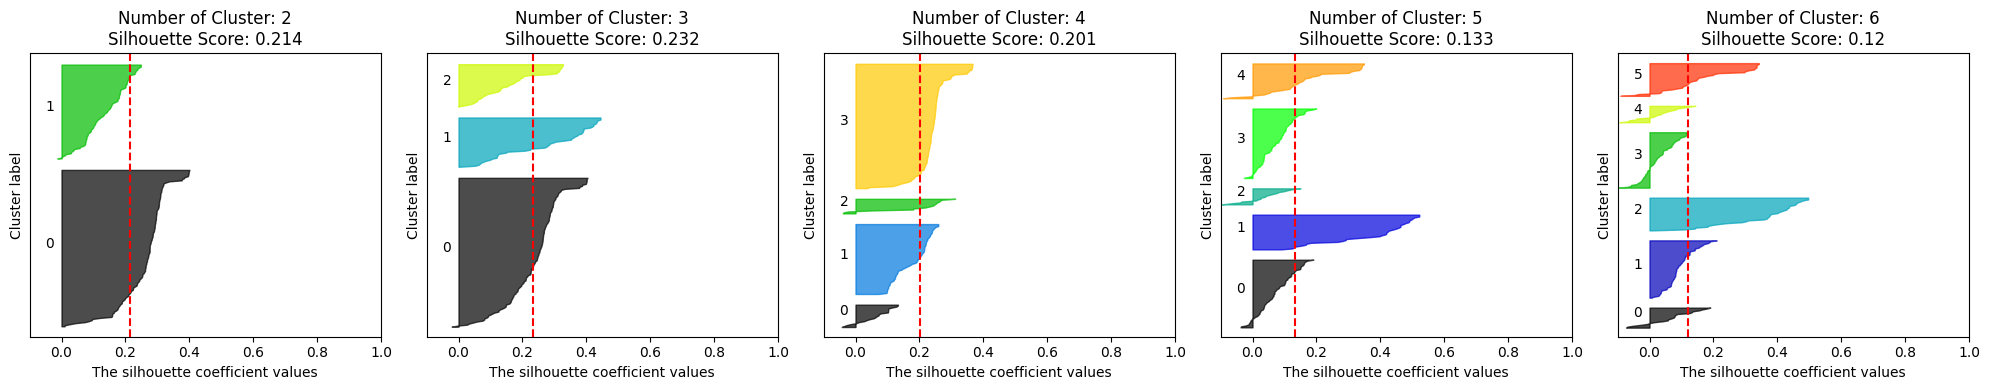

In [84]:
visualize_silhouette(range(2, 7), data_scaled)
plt.tight_layout()
plt.show()

In [85]:
cluster_df = pd.DataFrame(columns=['disk_id','cluster'])
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", verbose=False)
cluster_df['disk_id'] = list(grouped.keys())
cluster_df['cluster'] = km_dtw.fit_predict(data_scaled)
cluster_df.to_csv('cluster_result2.csv')

In [86]:
disk_id0 = list(cluster_df[cluster_df['cluster']==0]['disk_id'])
disk_id1 = list(cluster_df[cluster_df['cluster']==1]['disk_id'])
disk_id2 = list(cluster_df[cluster_df['cluster']==2]['disk_id'])
cluster0 = fail_disk_interpolated[fail_disk_interpolated['disk_id'].isin(disk_id0)]
cluster1 = fail_disk_interpolated[fail_disk_interpolated['disk_id'].isin(disk_id1)]
cluster2 = fail_disk_interpolated[fail_disk_interpolated['disk_id'].isin(disk_id2)]

In [97]:
cluster2 = cluster2.drop(columns=['ds','label'])
grouped_2 = cluster2.groupby("disk_id").apply(np.array)
to_cluster_raw_2 = np.array(grouped_2.tolist())
to_cluster2 = to_cluster_raw_2[:, :, 1:] # disk_id 제외
print('-- Finish Preparing Clustering Data --')

-- Finish Preparing Clustering Data --


In [98]:
cluster0_mean = np.mean(to_cluster0, axis=0)
cluster1_mean = np.mean(to_cluster1, axis=0)
cluster2_mean = np.mean(to_cluster2, axis=0)

In [105]:
cluster0_mean

array([[2.75000000e+00, 1.38310864e+04, 2.06204545e+01, 2.56354545e+02,
        6.50637500e+03, 2.50000000e-02, 0.00000000e+00, 2.75000000e+00,
        0.00000000e+00, 5.74115000e+03, 2.71522727e+01, 2.71522727e+01,
        5.74115000e+03, 3.50000000e-01, 8.07695272e+11, 5.84987166e+11],
       [2.80000000e+00, 1.38545705e+04, 2.06318182e+01, 2.57243182e+02,
        6.50632500e+03, 2.50000000e-02, 0.00000000e+00, 2.80000000e+00,
        0.00000000e+00, 5.74115000e+03, 2.72090909e+01, 2.72090909e+01,
        5.74115000e+03, 3.50000000e-01, 8.10147838e+11, 5.86396984e+11],
       [2.80000000e+00, 1.38780795e+04, 2.06431818e+01, 2.57806818e+02,
        6.50632500e+03, 2.50000000e-02, 0.00000000e+00, 2.80000000e+00,
        0.00000000e+00, 5.74115000e+03, 2.66659091e+01, 2.66659091e+01,
        5.74115000e+03, 3.50000000e-01, 8.11479185e+11, 5.87253971e+11],
       [2.80000000e+00, 1.39016136e+04, 2.06545455e+01, 2.58145455e+02,
        6.50632500e+03, 2.50000000e-02, 0.00000000e+00, 2.800

In [104]:
cluster0_mean[0]

array([2.75000000e+00, 1.38310864e+04, 2.06204545e+01, 2.56354545e+02,
       6.50637500e+03, 2.50000000e-02, 0.00000000e+00, 2.75000000e+00,
       0.00000000e+00, 5.74115000e+03, 2.71522727e+01, 2.71522727e+01,
       5.74115000e+03, 3.50000000e-01, 8.07695272e+11, 5.84987166e+11])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


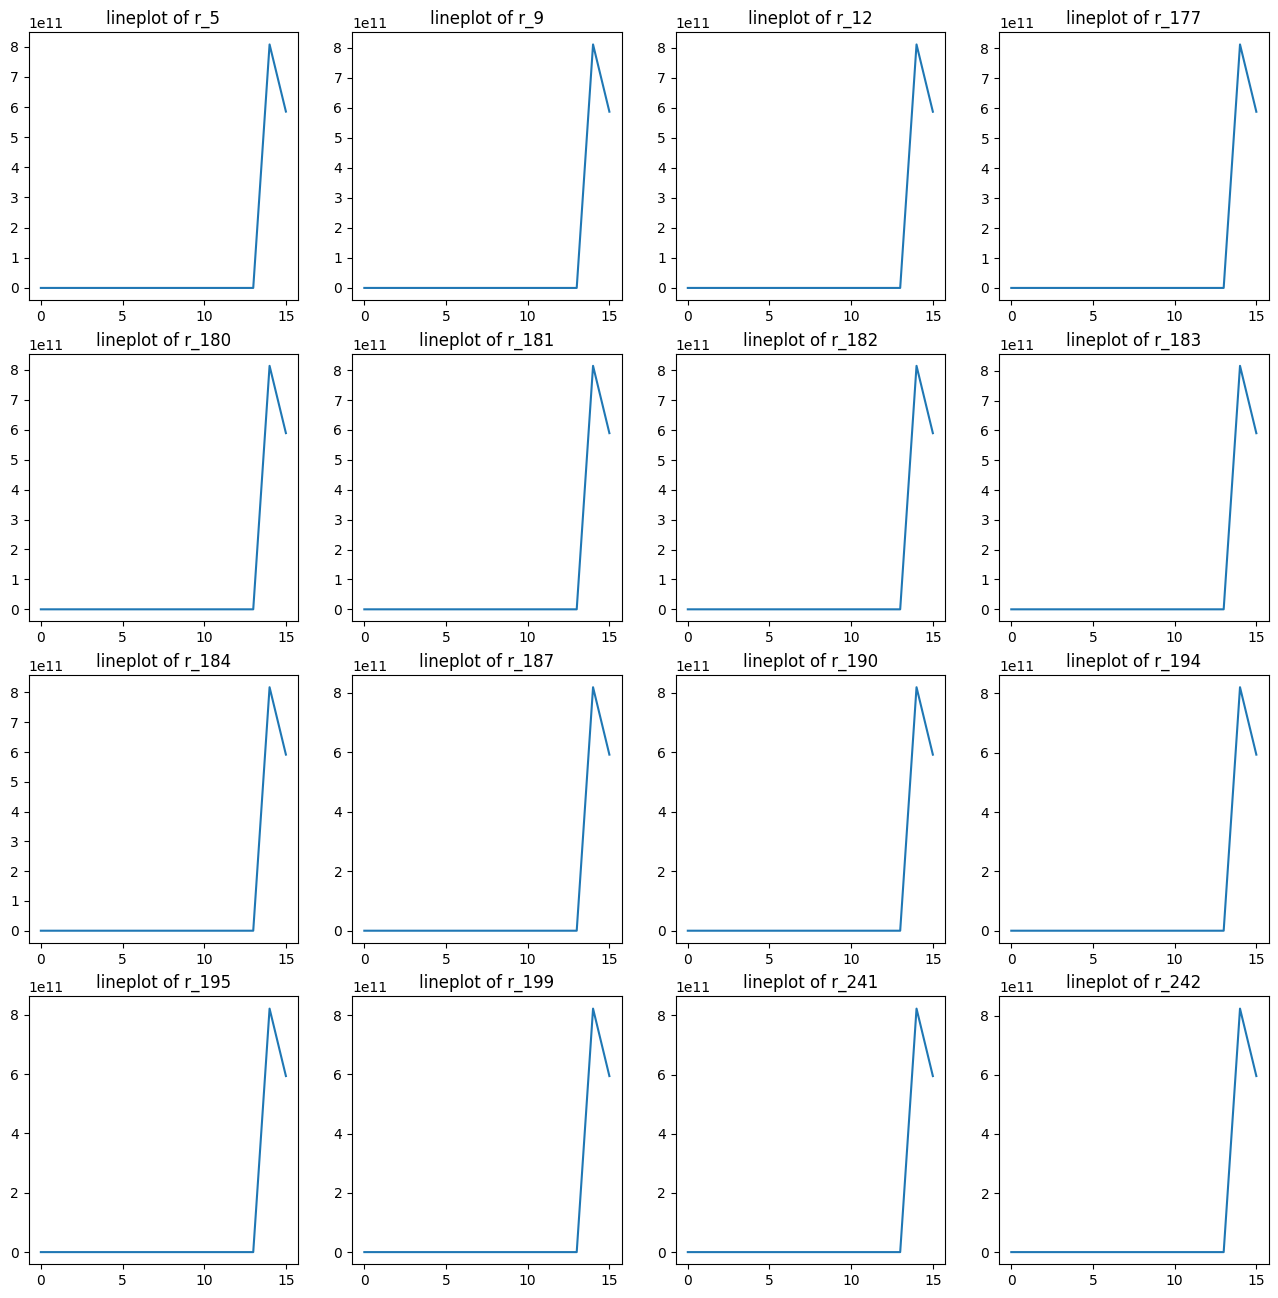

In [102]:
cols = list(fail_disk_interpolated.columns)
cols = [x for x in cols if x not in ['ds','disk_id','label']]
fig, axs = plt.subplots(figsize=(16, 16), nrows=4, ncols=4)
for ind, col in enumerate(cols):
    print(ind)
    x_axis = ind//4
    y_axis = ind%4
    axs[x_axis][y_axis].set_title(f'lineplot of {col}')
    axs[x_axis][y_axis].plot(cluster0_mean[:][ind])

In [88]:
def same_cluster_visualize(df, cluster0, cluster1, cluster2):
    cols = list(df.columns)
    cols = [x for x in cols if x not in ['ds','disk_id','label']]
    fig, axs = plt.subplots(figsize=(12, 12), nrows=4, ncols=4)

    for ind, col in enumerate(cols):
        x_axis = ind//4
        y_axis = ind%4
        axs[x_axis][y_axis].set_title(f'lineplot of {col}')
        axs[x_axis][y_axis].plot(cluster0[])


AttributeError: 'numpy.ndarray' object has no attribute 'head'

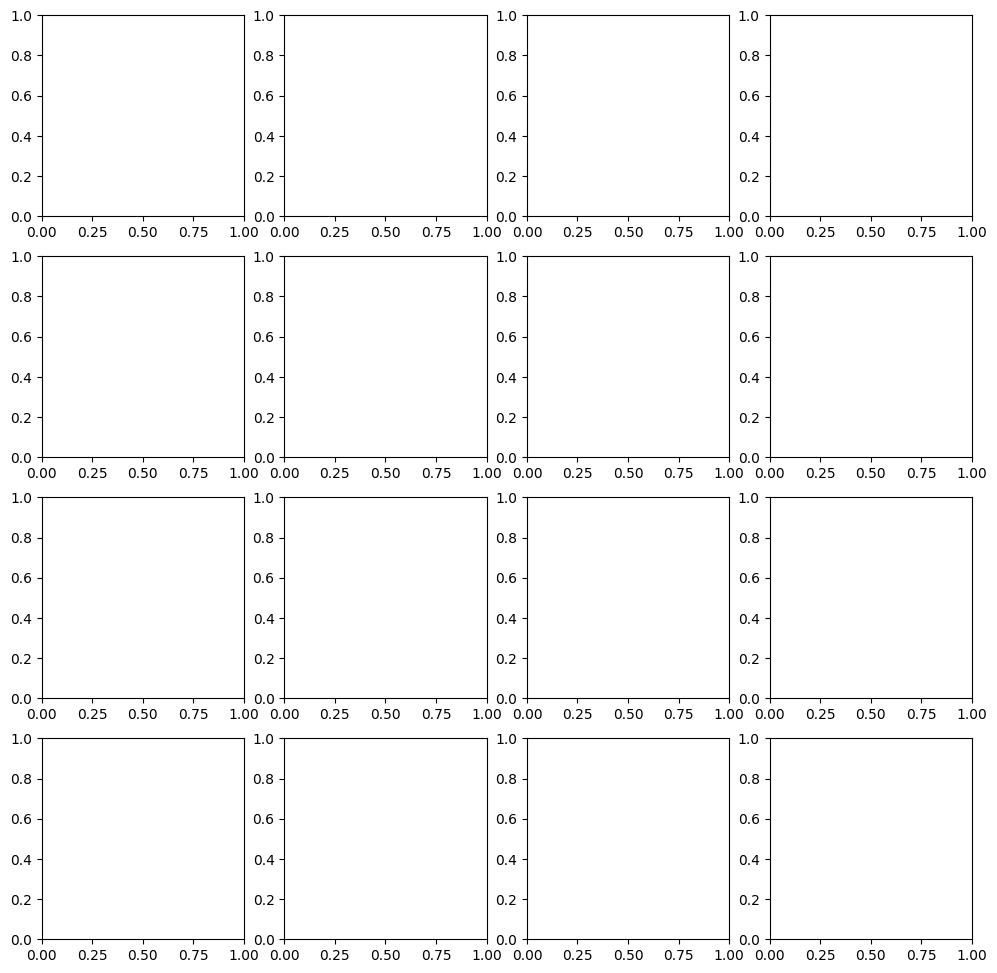

In [89]:
same_cluster_visualize(cluster0)
plt.suptitle('cluster',fontsize=20)
fig.tight_layout()
plt.show()

In [52]:
cluster0.shape
cluster0 = cluster0.drop(columns=['ds','label'])
grouped_0 = cluster0.groupby("disk_id").apply(np.array)
to_cluster_raw_0 = np.array(grouped_0.tolist())
to_cluster0 = to_cluster_raw_0[:, :, 1:] # disk_id 제외
print('-- Finish Preparing Clustering Data --')

-- Finish Preparing Clustering Data --


In [55]:
cluster0.head()

,disk_id,r_5,r_9,r_12,r_177,r_180,r_181,r_182,r_183,r_184,r_187,r_190,r_194,r_195,r_199,r_241,r_242
54,476.0,26.0,15574.0,18.0,8.0,6481.0,0.0,0.0,26.0,0.0,229624.0,29.0,29.0,229624.0,0.0,1.462815e+10,9.413783e+09
55,476.0,26.0,15598.0,18.0,8.0,6481.0,0.0,0.0,26.0,0.0,229624.0,28.0,28.0,229624.0,0.0,1.462815e+10,9.415186e+09
56,476.0,26.0,15622.0,18.0,8.0,6481.0,0.0,0.0,26.0,0.0,229624.0,28.0,28.0,229624.0,0.0,1.462815e+10,9.416450e+09
57,476.0,26.0,15646.0,18.0,8.0,6481.0,0.0,0.0,26.0,0.0,229624.0,28.0,28.0,229624.0,0.0,1.462815e+10,9.417780e+09
58,476.0,26.0,15670.0,18.0,8.0,6481.0,0.0,0.0,26.0,0.0,229624.0,29.0,29.0,229624.0,0.0,1.462815e+10,9.419018e+09


In [69]:
cluster0.describe()

,disk_id,r_5,r_9,r_12,r_177,r_180,r_181,r_182,r_183,r_184,r_187,r_190,r_194,r_195,r_199,r_241,r_242
count,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.00000,1200.0,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1.200000e+03,1.200000e+03
mean,25229.60000,2.911667,14172.904015,20.771061,261.969773,6506.213333,0.02500,0.0,2.911667,0.005000,5741.190833,27.550303,27.550303,5741.190833,0.351667,8.233889e+11,5.957820e+11
std,13109.17155,5.577525,2172.674051,5.698318,150.134958,47.584035,0.15619,0.0,5.577525,0.070563,35864.887826,2.705127,2.705127,35864.887826,0.691662,4.864000e+11,3.181816e+11
min,476.00000,0.000000,6985.000000,5.000000,1.000000,6343.000000,0.00000,0.0,0.000000,0.000000,0.000000,23.000000,23.000000,0.000000,0.000000,2.650630e+09,2.640407e+09
25%,11462.75000,0.000000,13547.750000,18.750000,125.000000,6484.000000,0.00000,0.0,0.000000,0.000000,0.000000,25.818182,25.818182,0.000000,0.000000,3.786040e+11,3.266780e+11
50%,25772.50000,2.000000,14936.000000,20.000000,278.000000,6518.000000,0.00000,0.0,2.000000,0.000000,0.000000,26.454545,26.454545,0.000000,0.000000,9.340996e+11,6.824426e+11
75%,36228.75000,2.000000,15363.181818,22.000000,395.000000,6533.750000,0.00000,0.0,2.000000,0.000000,0.000000,29.636364,29.636364,0.000000,1.000000,1.223105e+12,8.368498e+11
max,42493.00000,28.000000,17380.000000,39.000000,570.000000,6590.000000,1.00000,0.0,28.000000,1.000000,229624.000000,39.000000,39.000000,229624.000000,3.000000,2.114477e+12,1.493543e+12


In [71]:
cluster0[cluster0['disk_id']==476].describe()

,disk_id,r_5,r_9,r_12,r_177,r_180,r_181,r_182,r_183,r_184,r_187,r_190,r_194,r_195,r_199,r_241,r_242
count,30.0,30.000000,30.000000,30.0,30.000000,30.000000,30.0,30.0,30.000000,30.0,30.0,30.000000,30.000000,30.0,30.0,3.000000e+01,3.000000e+01
mean,476.0,27.333333,15922.000000,18.0,8.266667,6479.666667,0.0,0.0,27.333333,0.0,229624.0,28.866667,28.866667,229624.0,0.0,1.462815e+10,9.431861e+09
std,0.0,0.958927,211.281802,0.0,0.449776,0.958927,0.0,0.0,0.958927,0.0,0.0,0.345746,0.345746,0.0,0.0,5.259326e+01,1.068607e+07
min,476.0,26.000000,15574.000000,18.0,8.000000,6479.000000,0.0,0.0,26.000000,0.0,229624.0,28.000000,28.000000,229624.0,0.0,1.462815e+10,9.413783e+09
25%,476.0,26.000000,15748.000000,18.0,8.000000,6479.000000,0.0,0.0,26.000000,0.0,229624.0,29.000000,29.000000,229624.0,0.0,1.462815e+10,9.422957e+09
50%,476.0,28.000000,15922.000000,18.0,8.000000,6479.000000,0.0,0.0,28.000000,0.0,229624.0,29.000000,29.000000,229624.0,0.0,1.462815e+10,9.432436e+09
75%,476.0,28.000000,16096.000000,18.0,8.750000,6481.000000,0.0,0.0,28.000000,0.0,229624.0,29.000000,29.000000,229624.0,0.0,1.462815e+10,9.440475e+09
max,476.0,28.000000,16270.000000,18.0,9.000000,6481.000000,0.0,0.0,28.000000,0.0,229624.0,29.000000,29.000000,229624.0,0.0,1.462815e+10,9.449033e+09


In [67]:
np.average(to_cluster0,axis=0)

array([[2.75000000e+00, 1.38310864e+04, 2.06204545e+01, 2.56354545e+02,
        6.50637500e+03, 2.50000000e-02, 0.00000000e+00, 2.75000000e+00,
        0.00000000e+00, 5.74115000e+03, 2.71522727e+01, 2.71522727e+01,
        5.74115000e+03, 3.50000000e-01, 8.07695272e+11, 5.84987166e+11],
       [2.80000000e+00, 1.38545705e+04, 2.06318182e+01, 2.57243182e+02,
        6.50632500e+03, 2.50000000e-02, 0.00000000e+00, 2.80000000e+00,
        0.00000000e+00, 5.74115000e+03, 2.72090909e+01, 2.72090909e+01,
        5.74115000e+03, 3.50000000e-01, 8.10147838e+11, 5.86396984e+11],
       [2.80000000e+00, 1.38780795e+04, 2.06431818e+01, 2.57806818e+02,
        6.50632500e+03, 2.50000000e-02, 0.00000000e+00, 2.80000000e+00,
        0.00000000e+00, 5.74115000e+03, 2.66659091e+01, 2.66659091e+01,
        5.74115000e+03, 3.50000000e-01, 8.11479185e+11, 5.87253971e+11],
       [2.80000000e+00, 1.39016136e+04, 2.06545455e+01, 2.58145455e+02,
        6.50632500e+03, 2.50000000e-02, 0.00000000e+00, 2.800